# Trabajo Grafos: Red de Empresas Colaboradoras de la EII

## Optimización y Complejidad - Curso 2020/21 - Daniel Fernández Martínez

### Librerías necesarias

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import networkx as nx
import csv
from matplotlib import pyplot as plt
from operator import itemgetter
from community import community_louvain
from opencage.geocoder import OpenCageGeocode
from mpl_toolkits.basemap import Basemap as Basemap

### Preparación de datos

#### Web scraping

In [2]:
# URL del portal de empleo de la EII
url_to_scrape = "http://158.49.55.41/sg/eco_lista.asp"

# Método request para obtener la respuesta de la página
r = requests.get(url_to_scrape)

# Método BeatifulSoup para extraer información sobre la estructura html de la página
soup = BeautifulSoup(r.text)

# Lista para almacenar la información de cada empresa
nodes_list = []

# Recorremos la tabla de la base de datos de la página buscando los atributos html 'tr' y 'td'
for table_row in soup.select("table tr"):
	# Cada 'tr' (cada fila de la tabla), tiene 4 elementos 'td': nos quedaremos con los tres últimos
	cells = table_row.findAll('td')

	# Por si encontramos alguna fila vacía
	if len(cells) > 0:
        # Nombre de la empresa
		nombre = cells[1].text.strip()
        # Ubicación de la empresa
		localidad = cells[2].text.strip()
		# Número de convenios de prácticas creados hasta la fecha
		npracticas = cells[3].text.strip()
		# Diccionario para almacenar los datos extraídos
		node = {'Empresa': nombre.split(',')[0],'Localidad': localidad, 'Num': npracticas}
        # Añadimos un nuevo nodo a la lista
		nodes_list.append(node)


#### Convertimos la lista obtenida a DataFrame y exportamos como .csv

In [3]:
nodes_list[1:6]

[{'Empresa': '4TENERGY', 'Localidad': 'Málaga', 'Num': '0'},
 {'Empresa': '9 Ren España', 'Localidad': 'Madrid', 'Num': '1'},
 {'Empresa': 'A&b ZIN TECNICO S.L. (En trámite',
  'Localidad': 'Mérida',
  'Num': '3'},
 {'Empresa': 'ABALADOS', 'Localidad': 'Sevilla', 'Num': '1'},
 {'Empresa': 'ABBITAT - Servicio Integral de Cocinas y Armarios',
  'Localidad': 'Guadiana del Caudillo',
  'Num': '1'}]

In [4]:
data = pd.DataFrame.from_dict(nodes_list)
data = data.drop(0)
data.to_csv('nodos.csv', index=False)

In [5]:
data.head()

,Empresa,Localidad,Num
1,4TENERGY,Málaga,0
2,9 Ren España,Madrid,1
3,A&b ZIN TECNICO S.L. (En trámite,Mérida,3
4,ABALADOS,Sevilla,1
5,ABBITAT - Servicio Integral de Cocinas y Armarios,Guadiana del Caudillo,1


In [6]:
data.tail()

,Empresa,Localidad,Num
581,VIRAL STUDIOS C.B. (Viral Studios)Viral Studio...,Badajoz,5
582,VODAFONE ESPAÑA SAU (VODAFONE)Servicios de tel...,Madrid,1
583,VORSEVI,Badajoz,1
584,YNAR CONSULTORES TÉCNICOS S.L. (YNAR CONSULTOR...,Galaroza,1
585,Zorexsol,Don Benito,1


### Grafos

#### Red de empresas del Grado de Ingeniería Eléctrica

In [7]:
electrica = pd.read_csv('electrica.csv')
electrica.head()

,Empresa,Localidad,Num
0,A&b ZIN TECNICO S.L. (En trámite,Mérida,3
1,ACTEIN SERVICIOS S.L.Obras,Badajoz,4
2,Agencia Extremeña de la EnergíaAuditorías ener...,Badajoz,41
3,ALTER ENERSUN,Mérida,2
4,ANTONIO CARLOS PANIAGUA ZAMORA (En trámite,Azuaga,1


In [8]:
Gelectrica = nx.complete_graph(electrica['Empresa'].values.tolist())
nx.info(Gelectrica)

'Name: \nType: Graph\nNumber of nodes: 71\nNumber of edges: 2485\nAverage degree:  70.0000'

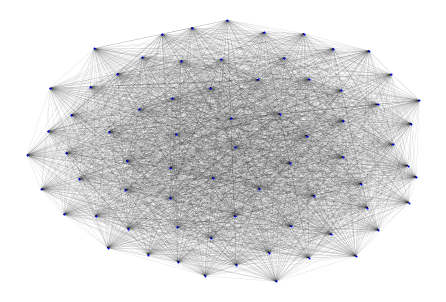

In [9]:
options = {
    'node_color': 'blue',
    'node_size': 1,
    'width': 0.05,
}
plt.figure()
nx.draw(Gelectrica, **options)
plt.show()

In [10]:
# Cargamos el csv de los nodos
with open('electrica.csv', encoding="utf8") as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]
    
# Creamos un diccionario para el atributo Num: keys (nombre del nodo), values (atributo)
num = {}
for node in nodes:
    num[node[0]] = node[2]
    
# Añadimos el atributo Num al grafo
nx.set_node_attributes(Gelectrica, num, 'weight')

# Convertimos el atributo Num, que es string, a int, para poder modificar el tamaño de los nodos
wg = list(map(int, num.values()))

# Creamos una lista de los nodos más grandes (con mayores Num)
largest = {}
dict_weight = nx.get_node_attributes(Gelectrica, 'weight')
for key in dict_weight:
    if int(dict_weight[key])>25:
        largest[key] = key.split(' ')[0]

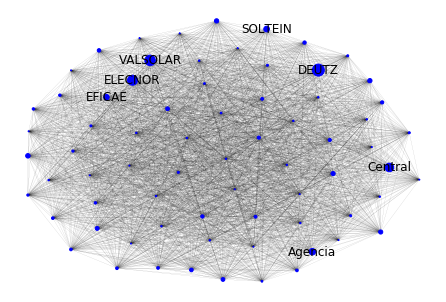

In [11]:
# Parámetros de visualización
options = {
    'node_color': 'blue',
    'width': 0.05,
    'node_size': wg,
    'with_labels': True,
    'labels': largest,
    'font_size': 12,
    'font_color': 'black'
}

# Visualizamos el grafo final
plt.figure()
nx.draw(Gelectrica, **options)
plt.show()

#### Red de empresas del Grado de Ingeniería Mecánica

In [12]:
mecanica = pd.read_csv('mecanica.csv')
mecanica

,Empresa,Localidad,Num
0,ABBITAT - Servicio Integral de Cocinas y Armarios,Guadiana del Caudillo,1
1,ACTEIN SERVICIOS S.L.Obras,Badajoz,4
2,Agencia Extremeña de la EnergíaAuditorías ener...,Badajoz,41
3,AGROINGEX S.L.Diseño de instalaciones eléctric...,Don Benito,1
4,ALBERALEX INGENIEROS,Hernán Cortes,1
...,...,...,...
119,TOMATES DEL GUADIANA S. COOPMANTENIMIENTO PREV...,Santa Amalia,2
120,U.T.E. MANTENIMIENTO OLIVENZAOPERACIÓN Y MANTE...,Mérida,5
121,VALSOLAR 2006,Badajoz,109
122,VEGENAT,Pueblonuevo del Guadiana,4


In [13]:
Gmecanica = nx.complete_graph(mecanica['Empresa'].values.tolist())
nx.info(Gmecanica)

'Name: \nType: Graph\nNumber of nodes: 124\nNumber of edges: 7626\nAverage degree: 123.0000'

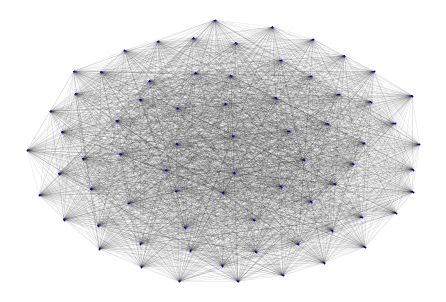

In [14]:
options = {
    'node_color': 'blue',
    'node_size': 1,
    'width': 0.05,
}

plt.figure()
nx.draw(Gelectrica, **options)
plt.show()

In [15]:
# Cargamos el csv de los nodos
with open('mecanica.csv', encoding="utf8") as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]
    
# Creamos un diccionario para el atributo Num: keys (nombre del nodo), values (atributo)
num = {}
for node in nodes:
    num[node[0]] = node[2]
    
# Añadimos el atributo Num al grafo
nx.set_node_attributes(Gmecanica, num, 'weight')

# Convertimos el atributo Num, que es string, a int, para poder modificar el tamaño de los nodos
wg = list(map(int, num.values()))

# Creamos una lista de los nodos más grandes (con mayores Num)
largest = {}
dict_weight = nx.get_node_attributes(Gmecanica, 'weight')
for key in dict_weight:
    if int(dict_weight[key])>15:
        largest[key] = key.split(' ')[0]

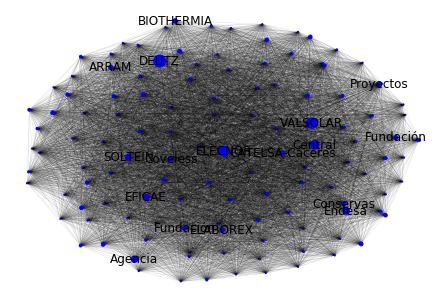

In [16]:
# Parámetros de visualización
options = {
    'node_color': 'blue',
    'width': 0.05,
    'node_size': wg,
    'with_labels': True,
    'labels': largest,
    'font_size': 12,
    'font_color': 'black'
}

plt.figure()
# Visualizamos el grafo final
nx.draw(Gmecanica, **options)
plt.show()

#### Red de empresas del Grado de Ingeniería Electrónica y Automática

In [17]:
electronica = pd.read_csv('electronica.csv')
electronica

,Empresa,Localidad,Num
0,A&b ZIN TECNICO S.L. (En trámite,Mérida,3
1,ADASA SISTEMAS S.A.U. (ADASA SISTEMAS S.A.U.)I...,El Prat de Llobregat,1
2,ARRAM Consultores,Badajoz,17
3,AVIZOR PORTAL DE SEGURIDAD S.L.Empresa de vigi...,Mérida,2
4,BANDAS CORTÉS S.L.,NaN,1
...,...,...,...
71,U.T.E. MANTENIMIENTO OLIVENZAOPERACIÓN Y MANTE...,Mérida,5
72,VALDEMAR INGENIEROS,Sevilla,2
73,VALSOLAR 2006,Badajoz,109
74,VIRAL STUDIOS C.B. (Viral Studios)Viral Studio...,Badajoz,5


In [18]:
Gelectronica = nx.complete_graph(electronica['Empresa'].values.tolist())
nx.info(Gelectronica)

'Name: \nType: Graph\nNumber of nodes: 76\nNumber of edges: 2850\nAverage degree:  75.0000'

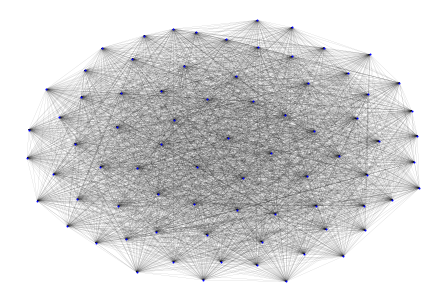

In [19]:
options = {
    'node_color': 'blue',
    'node_size': 1,
    'width': 0.05,
}

plt.figure()
nx.draw(Gelectronica, **options)
plt.show()

In [20]:
# Cargamos el csv de los nodos
with open('electronica.csv', encoding="utf8") as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]
    
# Creamos un diccionario para el atributo Num: keys (nombre del nodo), values (atributo)
num = {}
for node in nodes:
    num[node[0]] = node[2]
    
# Añadimos el atributo Num al grafo
nx.set_node_attributes(Gelectronica, num, 'weight')

# Convertimos el atributo Num, que es string, a int, para poder modificar el tamaño de los nodos
wg = list(map(int, num.values()))

# Creamos una lista de los nodos más grandes (con mayores Num)
largest = {}
dict_weight = nx.get_node_attributes(Gelectronica, 'weight')
for key in dict_weight:
    if int(dict_weight[key])>25:
        largest[key] = key.split(' ')[0]

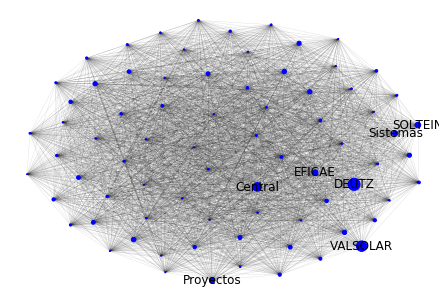

In [21]:
# Parámetros de visualización
options = {
    'node_color': 'blue',
    'width': 0.05,
    'node_size': wg,
    'with_labels': True,
    'labels': largest,
    'font_size': 12,
    'font_color': 'black'
}

# Visualizamos el grafo final
plt.figure()
nx.draw(Gelectronica, **options)
plt.show()

#### Red de empresas del Máster de Ingeniería Industrial

In [22]:
industrial = pd.read_csv('industrial.csv')
industrial

,Empresa,Localidad,Num
0,Agencia Extremeña de la EnergíaAuditorías ener...,Badajoz,41
1,ALTER ENERSUN,Mérida,2
2,AMG ENERGÍA Y TELECOMUNICACIONES S.L.Labores d...,Don Benito,1
3,ARQUIFAHO,Badajoz,8
4,AYESA INGENIERÍA Y ARQUITECTURA,NaN,2
5,CATELSA-Cáceres,Cáceres,18
6,Central Nuclear de AlmarazGeneración de energí...,Torrecilla de los Ángeles,74
7,COBRA INSTALACIONES Y SERVICIOS S.A.,Madrid,14
8,Conservas Vegetales de Extemadura,Villafranco del Guadiana,19
9,DISEC INGENIEROS C.B. (DISEC)Programación KNK,Badajoz,10


In [23]:
Gindustrial = nx.complete_graph(industrial['Empresa'].values.tolist())

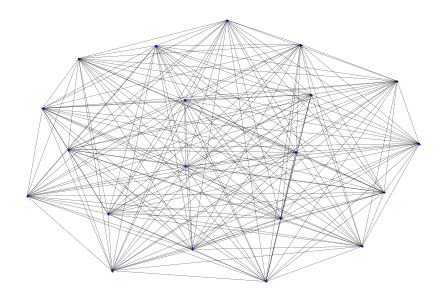

In [24]:
options = {
    'node_color': 'blue',
    'node_size': 1,
    'width': 0.2,
}

plt.figure()
nx.draw(Gindustrial, **options)
plt.show()

In [25]:
# Cargamos el csv de los nodos
with open('industrial.csv', encoding="utf8") as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]
    
# Creamos un diccionario para el atributo Num: keys (nombre del nodo), values (atributo)
num = {}
for node in nodes:
    num[node[0]] = node[2]
    
# Añadimos el atributo Num al grafo
nx.set_node_attributes(Gindustrial, num, 'weight')

# Convertimos el atributo Num, que es string, a int, para poder modificar el tamaño de los nodos
wg = list(map(int, num.values()))

# Creamos una lista de los nodos más grandes (con mayores Num)
largest = {}
dict_weight = nx.get_node_attributes(Gindustrial, 'weight')
for key in dict_weight:
    if int(dict_weight[key])>30:
        largest[key] = key.split(' ')[0]

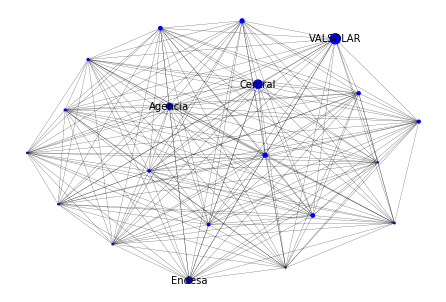

In [26]:
# Parámetros de visualización
options = {
    'node_color': 'blue',
    'width': 0.2,
    'node_size': wg,
    'with_labels': True,
    'labels': largest,
    'font_size': 10,
    'font_color': 'black'
}

# Visualizamos el grafo final
plt.figure()
nx.draw(Gindustrial, **options)
plt.show()

#### Obtención del Grafo final mediante composición de los anteriores

In [27]:
listG = [Gelectrica, Gmecanica, Gelectronica, Gindustrial]
Gfinal = nx.compose_all(listG)

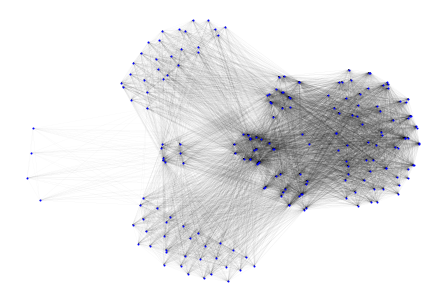

In [28]:
options = {
    'node_color': 'blue',
    'node_size': 1,
    'width': 0.01,
}

plt.figure()
nx.draw(Gfinal, **options)
plt.show()

In [29]:
# Convertimos el atributo 'weight', que es string, a int, para poder modificar el tamaño de los nodos
wg = list(map(int, nx.get_node_attributes(Gfinal, 'weight').values()))

# Creamos una lista de los nodos más grandes (con mayores Num)
largest = {}
dict_weight = nx.get_node_attributes(Gfinal, 'weight')
for key in dict_weight:
    if int(dict_weight[key])>20:
        largest[key] = key.split(' ')[0]

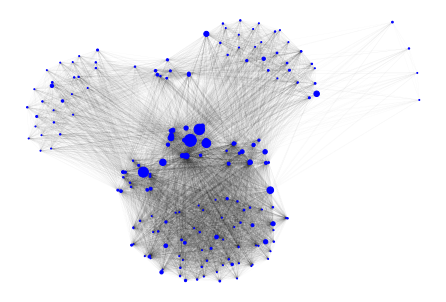

In [30]:
# Parámetros de visualización
options = {
    'node_color': 'blue',
    'width': 0.01,
    'node_size': wg,
    'with_labels': False,
    'labels': largest,
    'font_size': 15,
    'font_color': 'black'
}

# Visualizamos el grafo final
plt.figure()
nx.draw(Gfinal, **options)
plt.show()

## Análisis del Grafo completo

#### Información básica

In [31]:
print(nx.info(Gfinal))

Name: 
Type: Graph
Number of nodes: 196
Number of edges: 11644
Average degree: 118.8163


#### Densidad de la red

In [32]:
density = nx.density(Gfinal)
print("Densidad:", density)

Densidad: 0.6093144950287808


#### Matriz de adyacencia

In [33]:
A = nx.adjacency_matrix(Gfinal)
A.todense()

matrix([[0, 1, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 1, ..., 0, 1, 1],
        [0, 0, 1, ..., 1, 0, 1],
        [0, 0, 1, ..., 1, 1, 0]], dtype=int32)

#### Distribución de grado

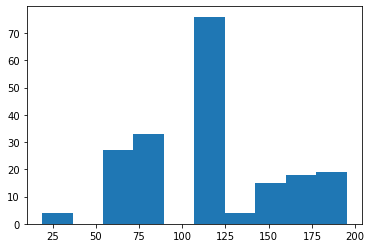

In [34]:
degrees = [Gfinal.degree(n) for n in Gfinal.nodes()]
plt.hist(degrees)
plt.show()

#### Degree centrality

In [35]:
nx.degree_centrality(Gfinal)

{'A&b ZIN TECNICO S.L. (En trámite': 0.6102564102564103,
 'ACTEIN SERVICIOS S.L.Obras': 0.8153846153846154,
 'Agencia Extremeña de la EnergíaAuditorías energéticas a Aytos.': 0.8461538461538461,
 'ALTER ENERSUN': 0.4205128205128205,
 'ANTONIO CARLOS PANIAGUA ZAMORA (En trámite': 0.358974358974359,
 'ARRAM Consultores': 0.9794871794871794,
 'ASETEX INGENIEROS': 0.358974358974359,
 'Ayuntamiento de Badajoz': 0.358974358974359,
 'BIOTHERMIA S.L.- Instalaciones térmicas e hidráulicas y mantenimiento.- Instalaciones de refrigeración industrial y mantenimiento.': 0.9794871794871794,
 'BOYMOSA': 0.358974358974359,
 'Business Development and Knowledge S.L. (BDK)Consultoría de NegocioDesarrollo de NegocioMarketingAsistencia ProfesionalRelaciones PúblicasServicios Técnicos de Elaboración de Estudios de Ingeniería': 0.358974358974359,
 'Cactus Servicios Energéticos S.L. (Cactus Servicios Energéticos) (En trámite': 0.358974358974359,
 'CATELSA-Cáceres': 1.0,
 'Central Nuclear de AlmarazGeneración 

#### Average neighbour degree

In [608]:
nx.average_neighbor_degree(Gfinal)

{'A&b ZIN TECNICO S.L. (En trámite': 119.4873949579832,
 'ACTEIN SERVICIOS S.L.Obras': 129.79245283018867,
 'Agencia Extremeña de la EnergíaAuditorías energéticas a Aytos.': 126.5030303030303,
 'ALTER ENERSUN': 124.71951219512195,
 'ANTONIO CARLOS PANIAGUA ZAMORA (En trámite': 129.44285714285715,
 'ARRAM Consultores': 120.52879581151832,
 'ASETEX INGENIEROS': 129.44285714285715,
 'Ayuntamiento de Badajoz': 129.44285714285715,
 'BIOTHERMIA S.L.- Instalaciones térmicas e hidráulicas y mantenimiento.- Instalaciones de refrigeración industrial y mantenimiento.': 120.52879581151832,
 'BOYMOSA': 129.44285714285715,
 'Business Development and Knowledge S.L. (BDK)Consultoría de NegocioDesarrollo de NegocioMarketingAsistencia ProfesionalRelaciones PúblicasServicios Técnicos de Elaboración de Estudios de Ingeniería': 129.44285714285715,
 'Cactus Servicios Energéticos S.L. (Cactus Servicios Energéticos) (En trámite': 129.44285714285715,
 'CATELSA-Cáceres': 118.42564102564103,
 'Central Nuclear de

#### Average degree connectivity

In [36]:
nx.average_degree_connectivity(Gfinal)

{119: 119.4873949579832,
 159: 129.79245283018867,
 165: 126.5030303030303,
 82: 124.71951219512195,
 70: 129.44285714285715,
 191: 120.52879581151832,
 195: 118.42564102564103,
 125: 116.424,
 123: 144.20325203252034,
 132: 138.65151515151516,
 163: 129.30674846625766,
 168: 126.36904761904762,
 75: 129.88,
 83: 124.33734939759036,
 19: 128.21052631578948}

#### Camino más corto entre 2 empresas

In [37]:
# Ejemplo 1
elecnor_deutz_path = nx.shortest_path(Gfinal, source="ELECNOR", target="DEUTZ SPAIN")
print("Camino más corto entre ELECNOR y DEUTZ SPAIN:", elecnor_deutz_path)
print("Longitud del camino:", len(elecnor_deutz_path)-1)

Camino más corto entre ELECNOR y DEUTZ SPAIN: ['ELECNOR', 'DEUTZ SPAIN']
Longitud del camino: 1


In [38]:
# Ejemplo 2
alter_vicente_path = nx.shortest_path(Gfinal, source="ALTER ENERSUN", target="VICENTE ACEDO")
print("Camino más corto entre ALTER ENERSUN y VICENTE ACEDO:", alter_vicente_path)
print("Longitud del camino:", len(alter_vicente_path)-1)

Camino más corto entre ALTER ENERSUN y VICENTE ACEDO: ['ALTER ENERSUN', 'ACTEIN SERVICIOS S.L.Obras', 'VICENTE ACEDO']
Longitud del camino: 2


#### Average shortest path length

In [39]:
nx.average_shortest_path_length(Gfinal)

1.3906855049712192

#### Diámetro de la red

In [40]:
nx.diameter(Gfinal)

2

#### Diámetro de la componente gigante

In [41]:
components = nx.connected_components(Gfinal)
largest_component = max(components, key=len)
subgraph = Gfinal.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Diámetro de la componente gigante:", diameter)

Diámetro de la componente gigante: 2


#### TOP 20 nodos en función del grado

In [42]:
degree_dict = dict(Gfinal.degree(Gfinal.nodes()))
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodos en función del grado:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodos en función del grado:
('CATELSA-Cáceres', 195)
('Central Nuclear de AlmarazGeneración de energía eléctrica de origen nuclear', 195)
('COBRA INSTALACIONES Y SERVICIOS S.A.', 195)
('VALSOLAR 2006', 195)
('ARRAM Consultores', 191)
('BIOTHERMIA S.L.- Instalaciones térmicas e hidráulicas y mantenimiento.- Instalaciones de refrigeración industrial y mantenimiento.', 191)
('CONSULTING DE ENERGÍAS RENOVABLES SIGLO XXI (EMECECUADRADO ING ENERGÉTICOS) (En trámite', 191)
('D.C.Gas Extremadura - Cristian Lay', 191)
('DEUTZ SPAIN', 191)
('DUCTOLUX', 191)
('EFICAE SOLUCIONES C.B. (EFICAE)Se realizan los siguientes servicios:Optimización y estudio de suministro eléctricoElaboración de informesAuditorías EnergéticasProyectos', 191)
('Fundación Centro Tecnológico Industrial de Extremadura (CETIEX)Innovación y proyectos de ingeniería', 191)
('Grupo Alfonso Gallardo', 191)
('INQUIBA S.A.', 191)
('J.G. Borrego Gabinete Pericial', 191)
('ONDUPACK', 191)
('Proyectos e Instalaciones Gregorio Ort

### Clustering

#### Clustering coefficient

In [43]:
nx.clustering(Gfinal)

{'A&b ZIN TECNICO S.L. (En trámite': 0.732801595214357,
 'ACTEIN SERVICIOS S.L.Obras': 0.7565480455377757,
 'Agencia Extremeña de la EnergíaAuditorías energéticas a Aytos.': 0.7142645971914264,
 'ALTER ENERSUN': 0.8464317976513098,
 'ANTONIO CARLOS PANIAGUA ZAMORA (En trámite': 1.0,
 'ARRAM Consultores': 0.6273353540920363,
 'ASETEX INGENIEROS': 1.0,
 'Ayuntamiento de Badajoz': 1.0,
 'BIOTHERMIA S.L.- Instalaciones térmicas e hidráulicas y mantenimiento.- Instalaciones de refrigeración industrial y mantenimiento.': 0.6273353540920363,
 'BOYMOSA': 1.0,
 'Business Development and Knowledge S.L. (BDK)Consultoría de NegocioDesarrollo de NegocioMarketingAsistencia ProfesionalRelaciones PúblicasServicios Técnicos de Elaboración de Estudios de Ingeniería': 1.0,
 'Cactus Servicios Energéticos S.L. (Cactus Servicios Energéticos) (En trámite': 1.0,
 'CATELSA-Cáceres': 0.6052868094105207,
 'Central Nuclear de AlmarazGeneración de energía eléctrica de origen nuclear': 0.6052868094105207,
 'CENTROW

#### Average clustering coefficient

In [44]:
nx.average_clustering(Gfinal)

0.9060366036407353

#### Communities

In [45]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

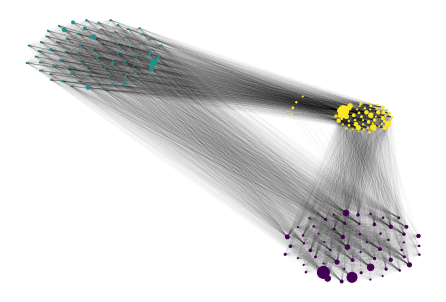

In [46]:
partition = community_louvain.best_partition(Gfinal)
pos = community_layout(Gfinal, partition)

# Parámetros de visualización
options = {
    'pos': pos,
    'node_color': list(partition.values()),
    'width': 0.01,
    'node_size': wg,
    'with_labels': False,
    'labels': largest,
    'font_size': 9,
    'font_color': 'black'
}

plt.figure()
nx.draw(Gfinal, **options)
plt.show()

### Ubicando los nodos en un mapa geográfico

#### Concatenamos los 4 dataframes de las titulaciones

In [47]:
df = pd.concat([electrica,mecanica,electronica,industrial]).drop_duplicates().reset_index(drop=True)
df_new = df.dropna()
df_new

,Empresa,Localidad,Num
0,A&b ZIN TECNICO S.L. (En trámite,Mérida,3
1,ACTEIN SERVICIOS S.L.Obras,Badajoz,4
2,Agencia Extremeña de la EnergíaAuditorías ener...,Badajoz,41
3,ALTER ENERSUN,Mérida,2
4,ANTONIO CARLOS PANIAGUA ZAMORA (En trámite,Azuaga,1
...,...,...,...
190,VIRAL STUDIOS C.B. (Viral Studios)Viral Studio...,Badajoz,5
191,VODAFONE ESPAÑA SAU (VODAFONE)Servicios de tel...,Madrid,1
192,AMG ENERGÍA Y TELECOMUNICACIONES S.L.Labores d...,Don Benito,1
194,LEMON SERVICIOS ENERGÉTICOS S.L. (LEMON SERVIC...,Badajoz,1


#### Obtenemos el listado de las empresas cuya localidad no es válida, para eliminar los nodos correspondientes

In [48]:
only_na = df[~df.index.isin(df_new.index)]
drop_nodes = only_na['Empresa'].values.tolist()
drop_nodes

['Ayuntamiento de Badajoz',
 'INQUIBA S.A.',
 'NESTLE ESPAÑA',
 'CONSEJERÍA DE SALUD Y POLÍTICA SOCIAL',
 'GRUPO CRISTIAN LAY',
 'ISOBER Ibérica',
 'BANDAS CORTÉS S.L.',
 'CONSEJO SUPERIOR DE INVESTIGACIONES CIENTÍFICAS',
 'Instituto Tecnológico Agroalimentario',
 'PROMUSICA',
 'AYESA INGENIERÍA Y ARQUITECTURA']

#### Reestablecemos el index df_new

In [49]:
df_new = df_new.reset_index(drop=True)
df_new

,Empresa,Localidad,Num
0,A&b ZIN TECNICO S.L. (En trámite,Mérida,3
1,ACTEIN SERVICIOS S.L.Obras,Badajoz,4
2,Agencia Extremeña de la EnergíaAuditorías ener...,Badajoz,41
3,ALTER ENERSUN,Mérida,2
4,ANTONIO CARLOS PANIAGUA ZAMORA (En trámite,Azuaga,1
...,...,...,...
180,VIRAL STUDIOS C.B. (Viral Studios)Viral Studio...,Badajoz,5
181,VODAFONE ESPAÑA SAU (VODAFONE)Servicios de tel...,Madrid,1
182,AMG ENERGÍA Y TELECOMUNICACIONES S.L.Labores d...,Don Benito,1
183,LEMON SERVICIOS ENERGÉTICOS S.L. (LEMON SERVIC...,Badajoz,1


#### Creamos el mapa con Basemap, especificando el modo de proyección y las coordenadas

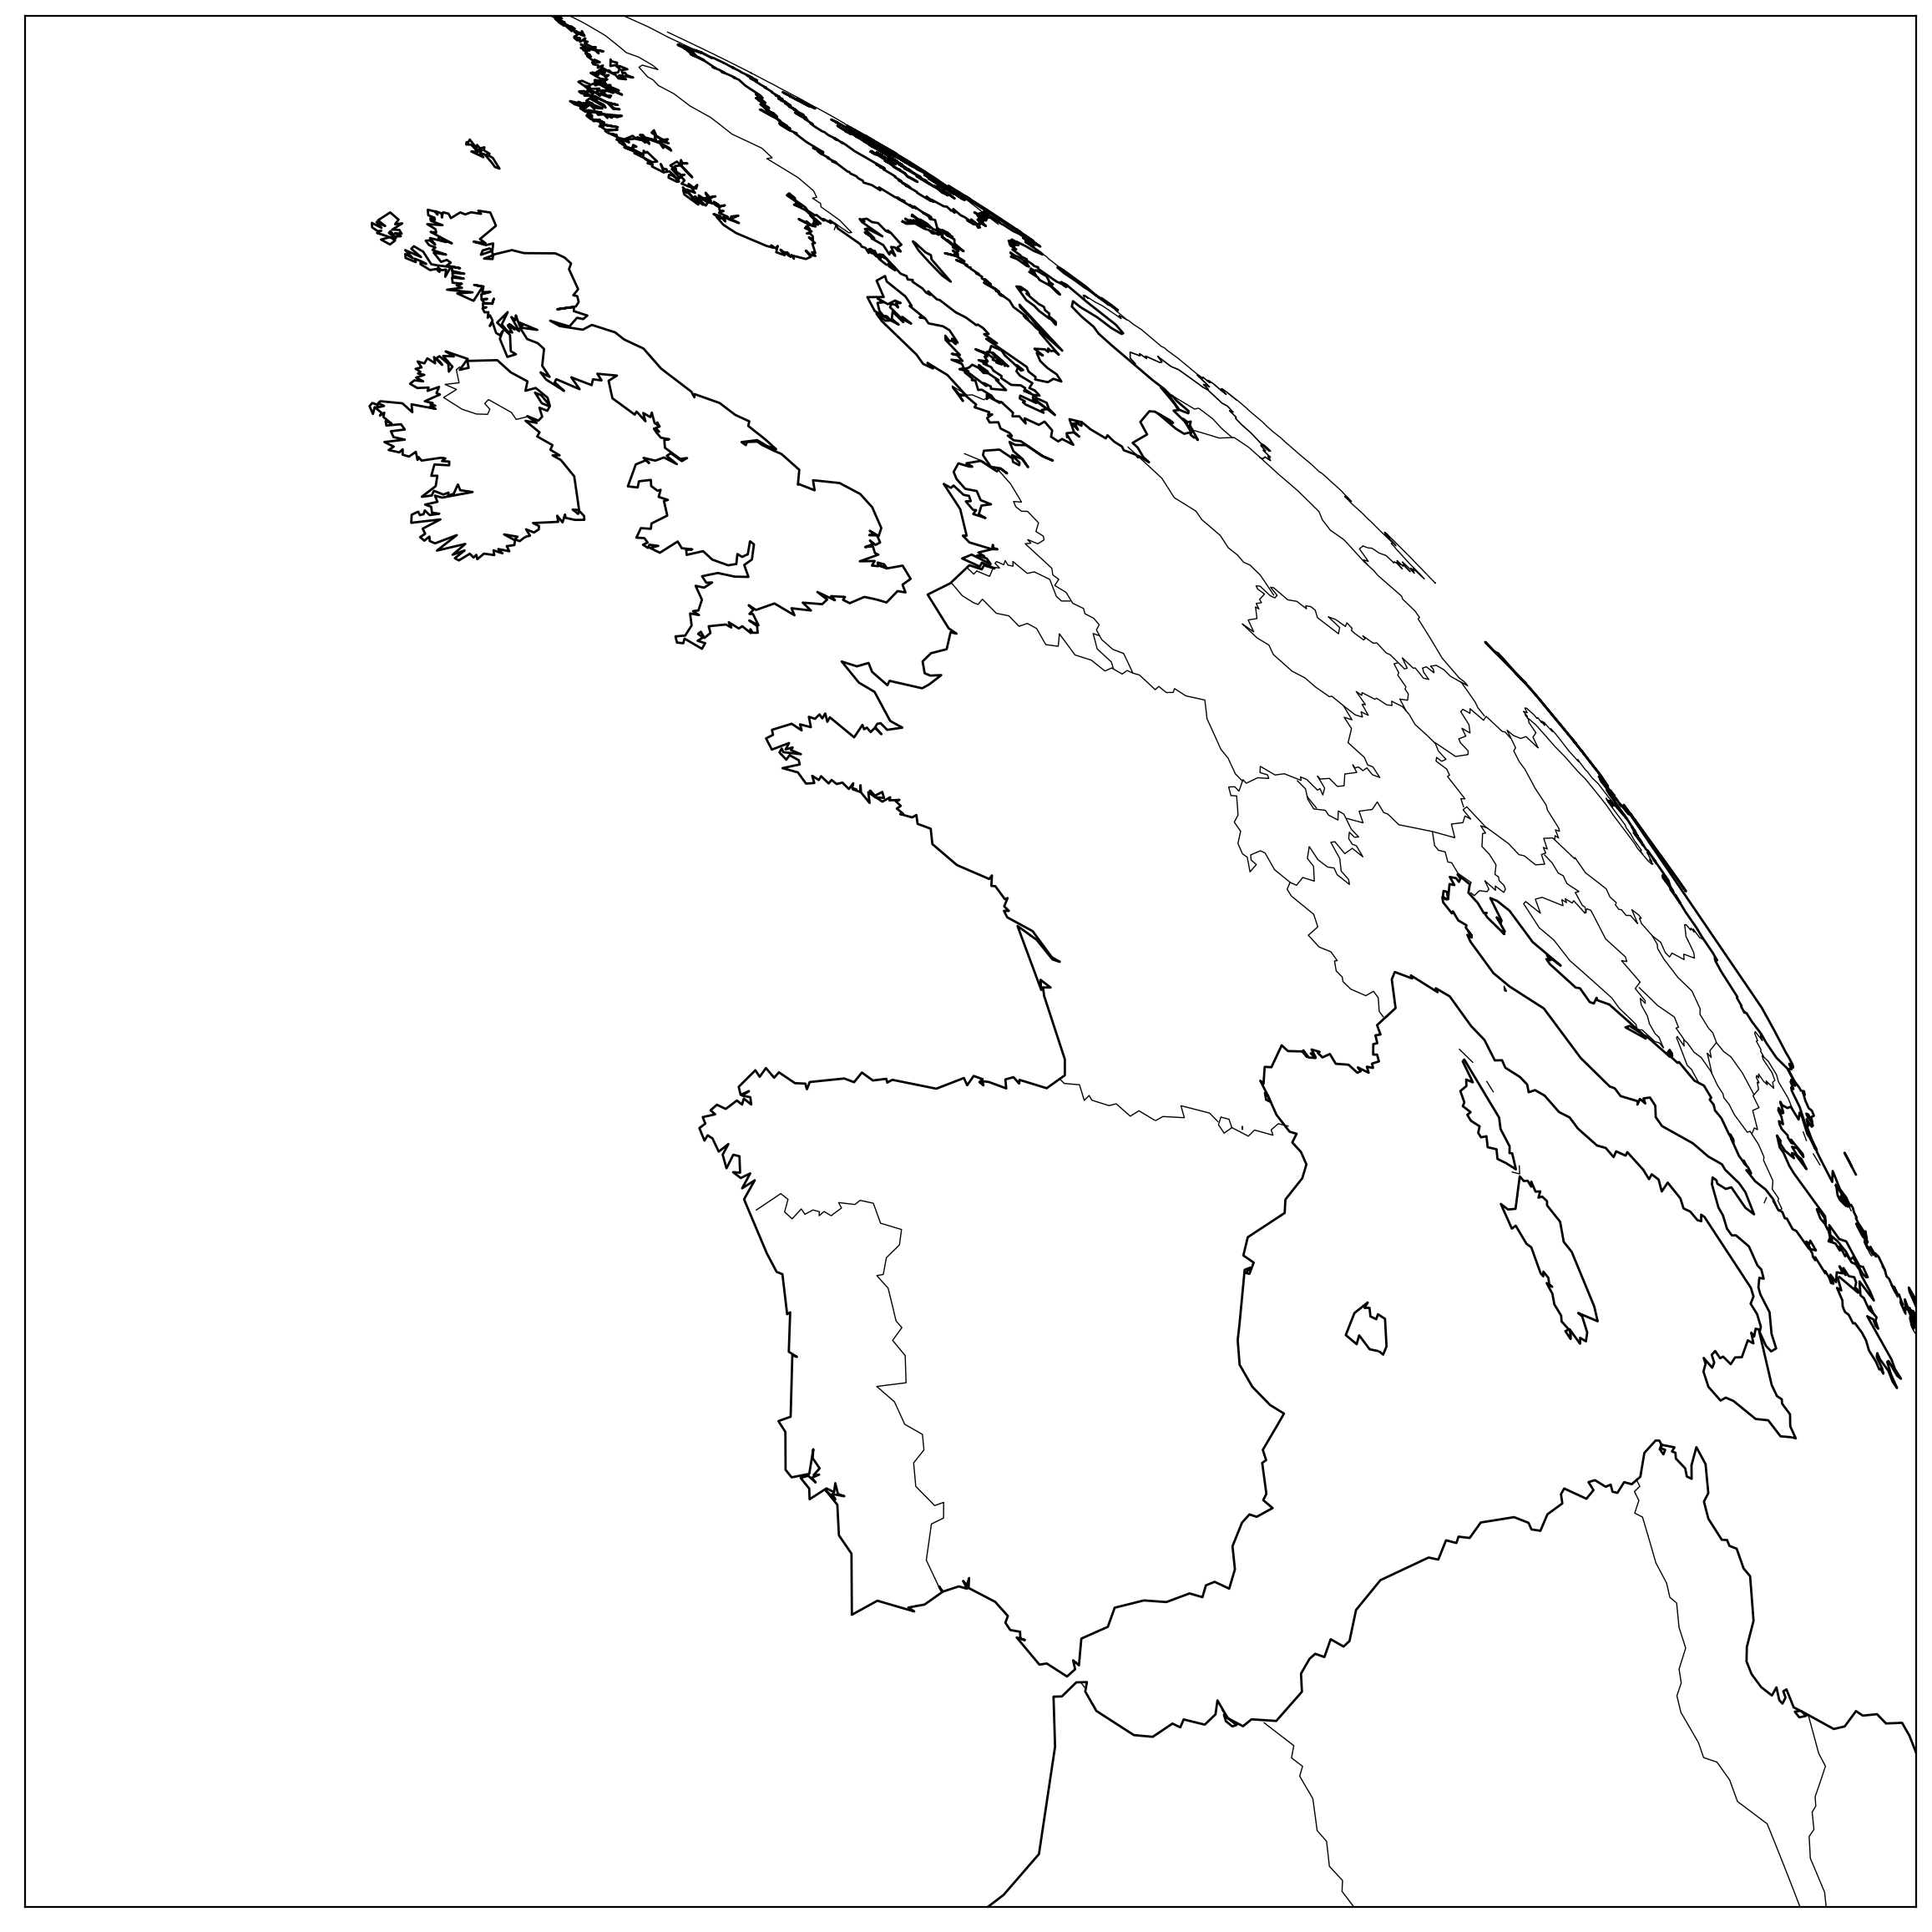

In [50]:
m = Basemap(resolution='l', 
              satellite_height=3500000.,
              projection='nsper', 
              lat_0 = 30., lon_0 = -27.,
              llcrnrx=500000.,llcrnry=500000.,urcrnrx=2700000.,urcrnry=2700000.
             )

plt.figure(figsize=(15, 15), dpi=200)
m.drawcoastlines() 
m.drawcountries()

#### Iteramos sobre las localidades del dataframe anterior para obtener las coordenadas geográficas de cada empresa a través de OpenCageGeocode

In [624]:
#m = Basemap(llcrnrlon=-10.5,llcrnrlat=35,urcrnrlon=4.,urcrnrlat=44.,
#             resolution='i', projection='tmerc', lat_0 = 39.5, lon_0 = -3.25)

key = 'b996bcef41254d15a4eecfc7c6980d51'
geocoder = OpenCageGeocode(key)

lnglat = {}
i = 0
for city in df_new['Localidad']:
    results = geocoder.geocode(city)
    lat = results[0]['geometry']['lat']
    lng = results[0]['geometry']['lng']
    mx,my = m(lng,lat)
    lnglat[df_new['Empresa'][i]] = mx, my
    i = i + 1

#### Verificamos que no haya ninguna coordenada errónea

In [625]:
lnglat

{'A&b ZIN TECNICO S.L. (En trámite': (4545864.90396021, 3999314.7511534784),
 'ACTEIN SERVICIOS S.L.Obras': (4507378.1247849595, 3991426.349259922),
 'Agencia Extremeña de la EnergíaAuditorías energéticas a Aytos.': (4507378.1247849595,
  3991426.349259922),
 'ALTER ENERSUN': (4545864.90396021, 3999314.7511534784),
 'ANTONIO CARLOS PANIAGUA ZAMORA (En trámite': (4605779.426279146,
  3941910.7312157406),
 'ARRAM Consultores': (4507378.1247849595, 3991426.349259922),
 'ASETEX INGENIEROS': (4549929.425325497, 3902636.538273542),
 'BIOTHERMIA S.L.- Instalaciones térmicas e hidráulicas y mantenimiento.- Instalaciones de refrigeración industrial y mantenimiento.': (4507378.1247849595,
  3991426.349259922),
 'BOYMOSA': (4528474.939264636, 4051351.726234242),
 'Business Development and Knowledge S.L. (BDK)Consultoría de NegocioDesarrollo de NegocioMarketingAsistencia ProfesionalRelaciones PúblicasServicios Técnicos de Elaboración de Estudios de Ingeniería': (4658356.204670493,
  4154129.951657

#### Eliminamos los nodos con coordenadas erróneas y los que su localidad es NaN (almecenados en drop_nodes)

In [626]:
Gfinal.remove_nodes_from(drop_nodes)
# Confunde Córdoba (España) con Córdoba (Argentina)
Gfinal.remove_node('MAGTEL OPERACIONES SLUMAGTEL realiza trabajos de diseño tecnológico')
# Confunde Cartagena (España) con Cartagena (Colombia)
Gfinal.remove_node('J.P. ALCARAZ ELECTRÓNICA S.L. (J.P. ALCARAZ ELECTRÓNICA )Electrónica IndustrialElectrónica NavalElectromercancías')

#### Añadimos al grafo las coordenadas anteriores como un nuevo atributo

In [627]:
nx.set_node_attributes(Gfinal, lnglat, 'coord')

#### Visualizamos el mapa con el grafo

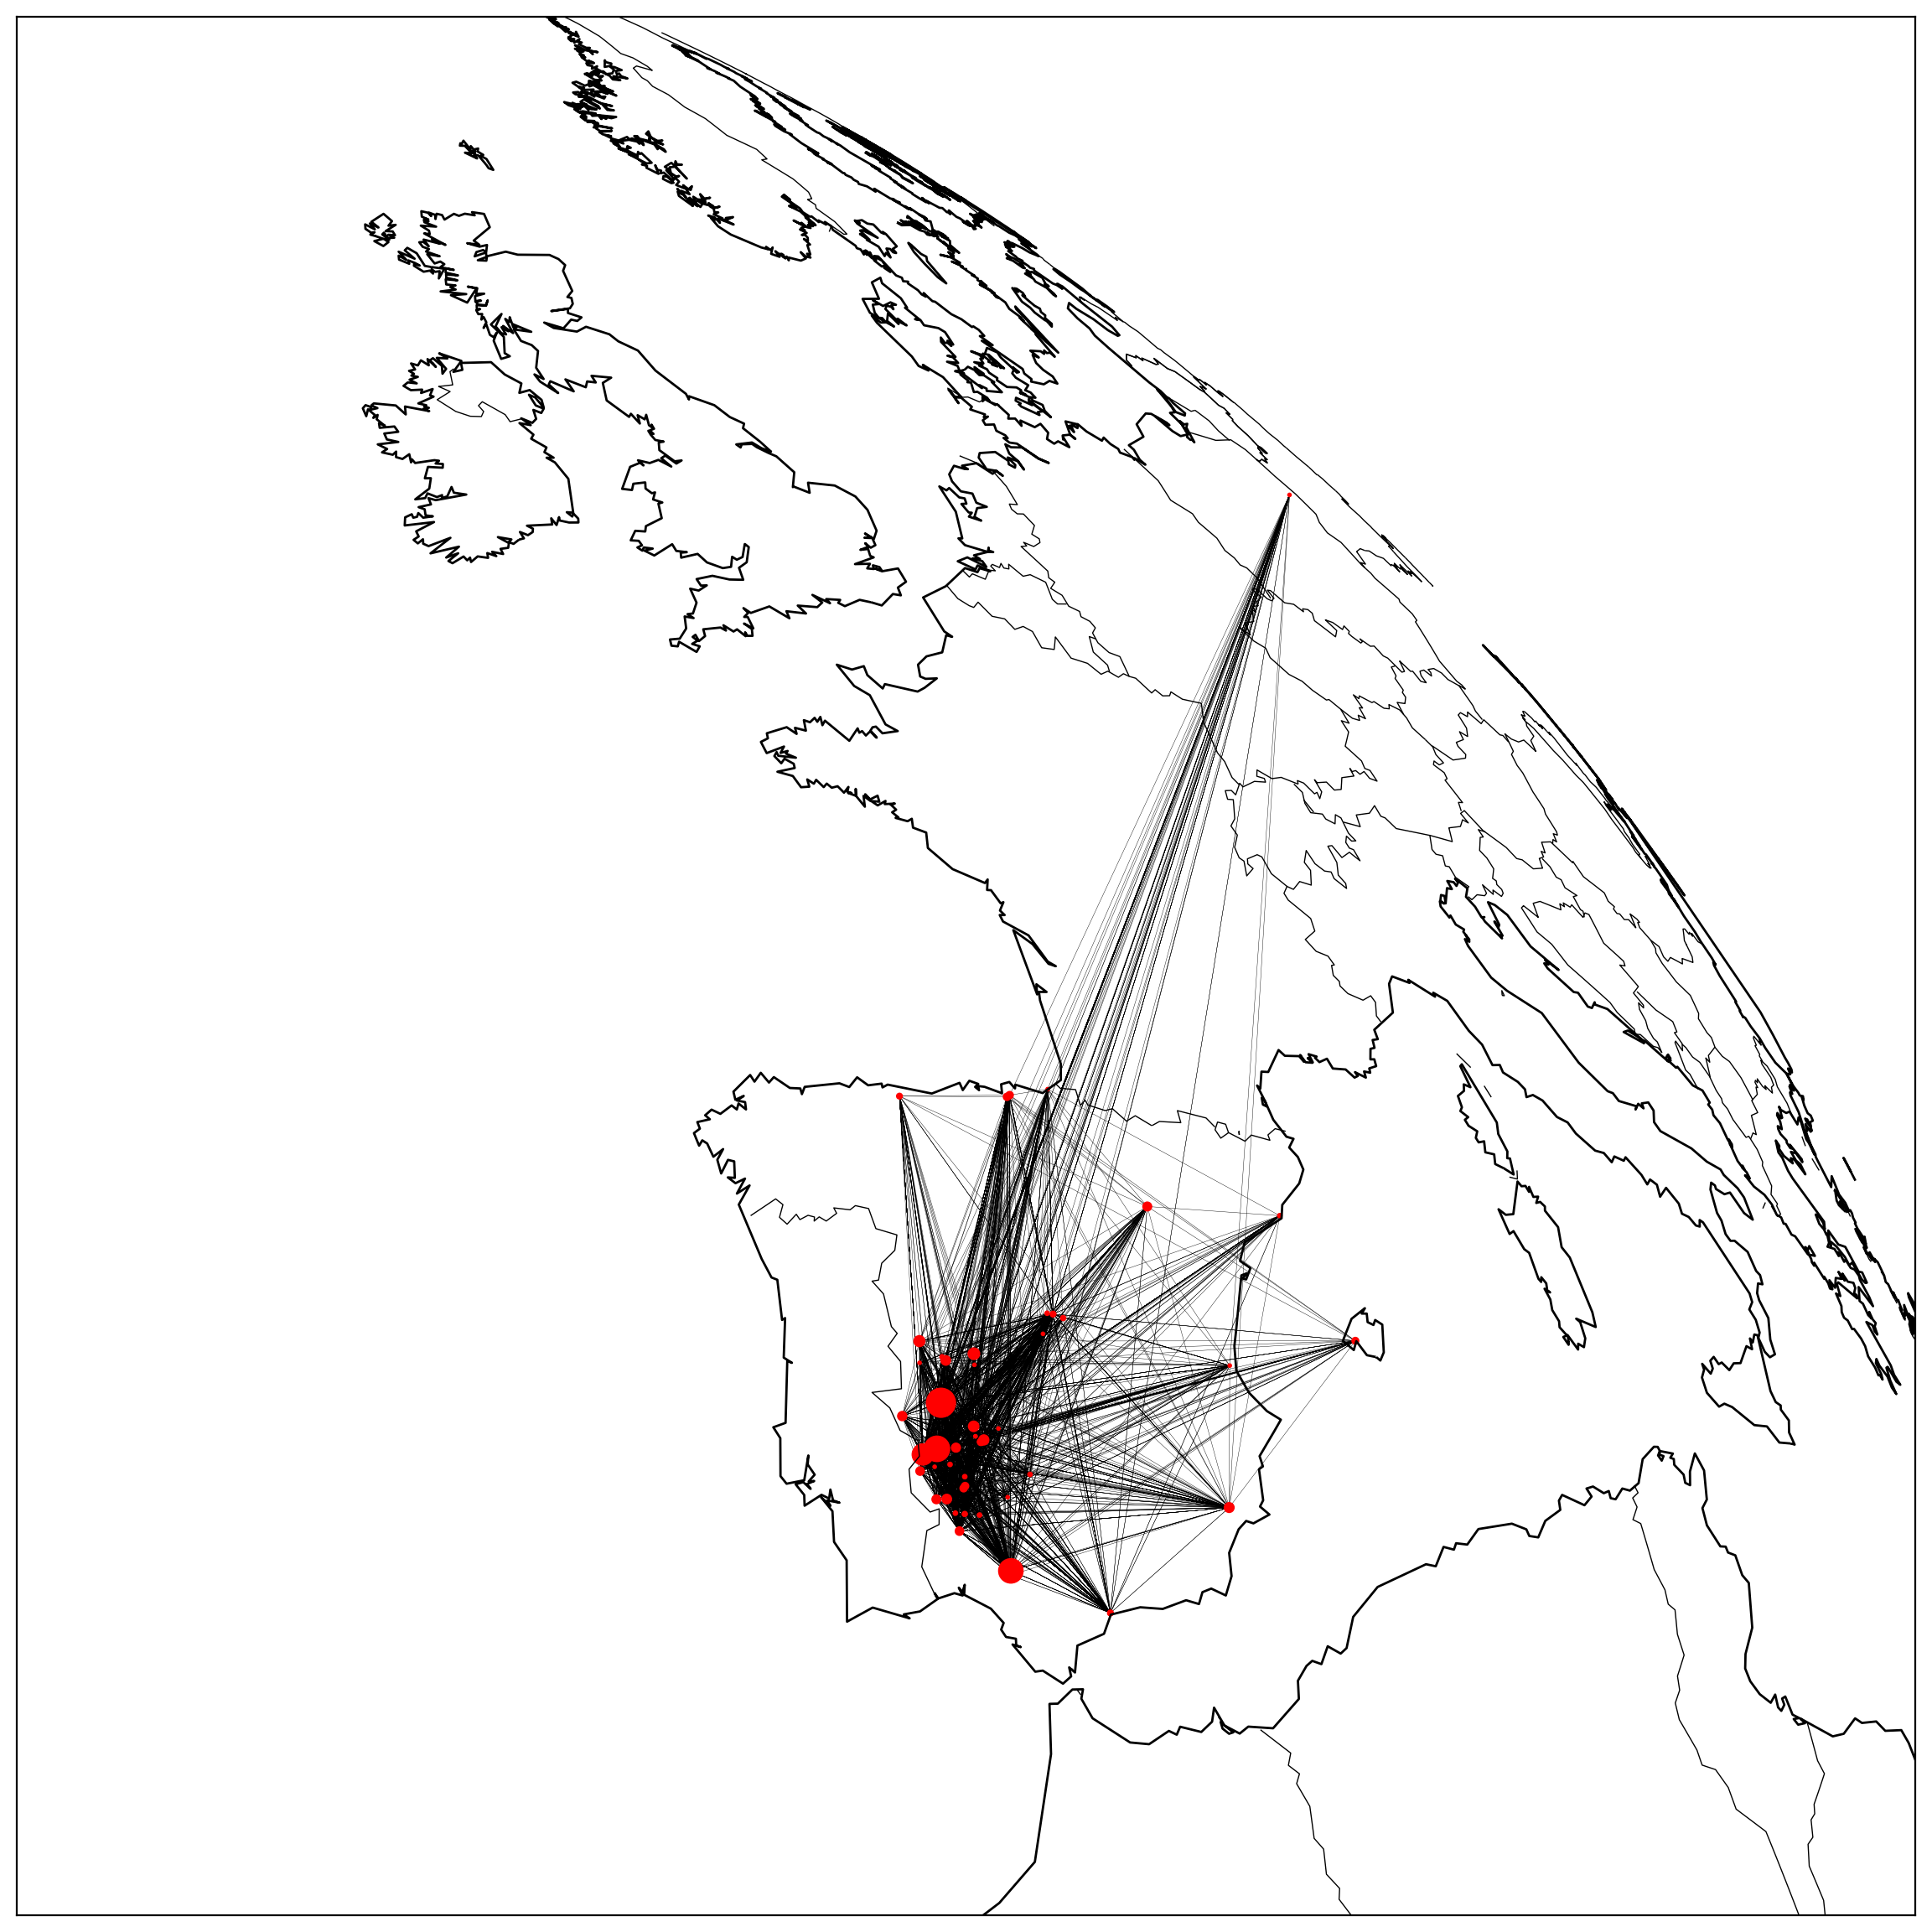

In [628]:
plt.figure(figsize=(15, 15), dpi=200)

pos = nx.get_node_attributes(Gfinal,'coord')
nx.draw_networkx(Gfinal, pos, node_size= wg, node_color='red',with_labels = False, width = 0.15)
m.drawcoastlines() 
m.drawcountries()